# Assignment 8: Correlation Analysis and Hypothesis Testing

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and hypothesis testing, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

**Correlation Analysis**
1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 


**Hypothesis Testing**
1. Why A/B testing?  
2. What is a permutation test? How to implement it?
3. What is p-value? How to avoid p-hacking? 
4. What is a chi-squared test? How to implement it?


In this assignment, you can use [pandas](https://pandas.pydata.org/) or PySpark to manipulate data, and use [matplotlib](https://matplotlib.org/) or [seaborn](seaborn.pydata.org) to make plots. 

## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a dataset from [property_tax_report_2018.zip](property_tax_report_2018.zip). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2018.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [1]:
import pandas as pd

df = pd.read_csv("property_tax_report_2018.csv")



In [2]:
df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE']+x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose <font color='blue'>postcode starts with 'V6A'</font>. Furthermore, we remove the houses that were <font color='blue'>built before 1900</font>.

<img src="img/v6a.png", width=500/>

In [3]:
valid_postal_code_length = 7
df = df.copy()[df['PROPERTY_POSTAL_CODE'] \
    .apply(lambda x: type(x).__name__ == 'str' and len(x) == valid_postal_code_length)]
df['POSTAL_CODE_SHORT'] = df \
    .apply(lambda x: x['PROPERTY_POSTAL_CODE'].split(' ')[0], axis = 1)
df = df[(df['POSTAL_CODE_SHORT'] == 'V6A')]

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

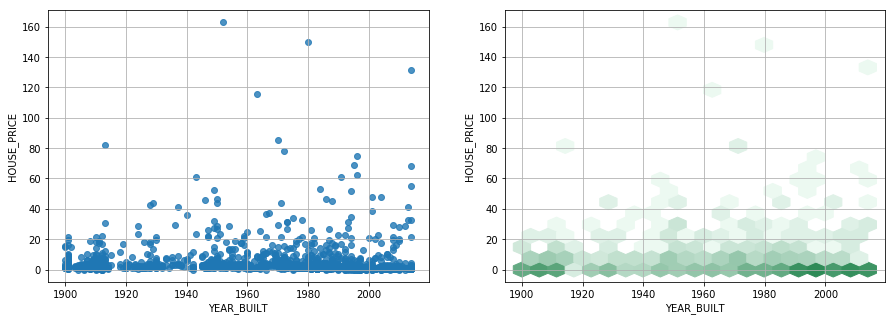

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
house_built_1900_2015 = df[(df['YEAR_BUILT'] >= 1900) & (df['YEAR_BUILT'] <= 2018)]
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

sns.regplot(x=house_built_1900_2015['YEAR_BUILT'], y=house_built_1900_2015['HOUSE_PRICE'], fit_reg=False, ax= ax1)
ax1.grid()

with sns.axes_style("white"):
    cmap = sns.light_palette("seagreen", as_cmap=True)
    ax2.hexbin(house_built_1900_2015['YEAR_BUILT'], house_built_1900_2015['HOUSE_PRICE'], gridsize=20, cmap=cmap, bins='log', mincnt=1)
    ax2.set_xlabel('YEAR_BUILT')
    ax2.set_ylabel('HOUSE_PRICE')
    ax2.grid()

plt.show()


Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. For last century majority plot price were below 40 millions.
2. Towards the end of century we have more properties overall and many of which has price higher that 40 million.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insight. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


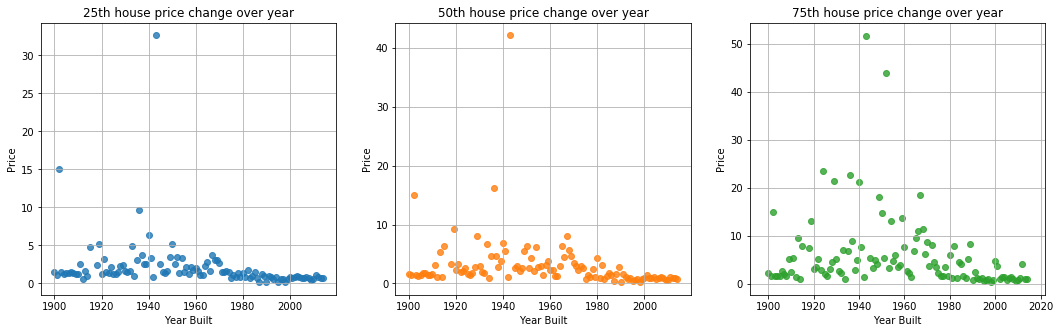

In [5]:
from math import isnan

twenty_fifth_per = []
fiftyth_per = []
seventy_fifth_per = []

for i  in range(1900,2015):
    house_built = house_built_1900_2015[house_built_1900_2015.YEAR_BUILT == i]
    twenty_fifth_house = house_built['HOUSE_PRICE'].quantile(.25)
    fiftyth_house = house_built['HOUSE_PRICE'].quantile(.50)
    seventy_fifth_house = house_built['HOUSE_PRICE'].quantile(.75)
    
    if isnan(float(twenty_fifth_house)):
        twenty_fifth_house = 0.0
    if isnan(float(fiftyth_house)):
        fiftyth_house = 0.0
    if isnan(float(seventy_fifth_house)):
        seventy_fifth_house = 0.0

    twenty_fifth_per.append(twenty_fifth_house)
    fiftyth_per.append(fiftyth_house)
    seventy_fifth_per.append(seventy_fifth_house)
    
d = {'YEAR_BUILT': np.array(range(1900,2015)), 
     'twenty_fifth_house': np.array(twenty_fifth_per),
     'fiftyth_house': np.array(fiftyth_per),
     'seventy_fifth_house': np.array(seventy_fifth_per)}
percentile_df = pd.DataFrame(data=d)
percentile_df = percentile_df[(percentile_df.twenty_fifth_house > 0)]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18,5))

sns.regplot(x=percentile_df['YEAR_BUILT'], y=percentile_df['twenty_fifth_house'], fit_reg=False, ax = ax1)
sns.regplot(x=percentile_df['YEAR_BUILT'], y=percentile_df['fiftyth_house'], fit_reg=False, ax = ax2)
sns.regplot(x=percentile_df['YEAR_BUILT'], y=percentile_df['seventy_fifth_house'], fit_reg=False, ax = ax3)
ax1.set(title = '25th house price change over year', xlabel = 'Year Built', ylabel = 'Price')
ax2.set(title = '50th house price change over year', xlabel = 'Year Built', ylabel = 'Price')
ax3.set(title = '75th house price change over year', xlabel = 'Year Built', ylabel = 'Price')

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. Over the last century majority property price was below 10 million and quarter of them were below 5 million over the years.
2. After 1980 there were more house built which value was between 0 - 10 million and at least three quarters of them were below 10 millions and quarters of them were below 3 million.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>, and then print out your results. 

Note that it is OK to use this [function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to do this task, but make sure that you understand how the numbers are computed. 

In [6]:
print('25th percentile')
print('Pearson: ')
print(percentile_df[['YEAR_BUILT', 'twenty_fifth_house']].corr(method='pearson'))
print('')
print('Spearmans: ')
print(percentile_df[['YEAR_BUILT', 'twenty_fifth_house']].corr(method='spearman'))

25th percentile
Pearson: 
                    YEAR_BUILT  twenty_fifth_house
YEAR_BUILT            1.000000           -0.244533
twenty_fifth_house   -0.244533            1.000000

Spearmans: 
                    YEAR_BUILT  twenty_fifth_house
YEAR_BUILT            1.000000           -0.572112
twenty_fifth_house   -0.572112            1.000000


In [7]:
print('50th percentile')
print('Pearson: ')
print(percentile_df[['YEAR_BUILT', 'fiftyth_house']].corr(method='pearson'))
print('')
print('Spearmans: ')
print(percentile_df[['YEAR_BUILT', 'fiftyth_house']].corr(method='spearman'))

50th percentile
Pearson: 
               YEAR_BUILT  fiftyth_house
YEAR_BUILT       1.000000      -0.237504
fiftyth_house   -0.237504       1.000000

Spearmans: 
               YEAR_BUILT  fiftyth_house
YEAR_BUILT       1.000000      -0.509847
fiftyth_house   -0.509847       1.000000


In [8]:
print('75th percentile')
print('Pearson: ')
print(percentile_df[['YEAR_BUILT', 'seventy_fifth_house']].corr(method='pearson'))
print('')
print('Spearmans: ')
print(percentile_df[['YEAR_BUILT', 'seventy_fifth_house']].corr(method='spearman'))

75th percentile
Pearson: 
                     YEAR_BUILT  seventy_fifth_house
YEAR_BUILT             1.000000            -0.212677
seventy_fifth_house   -0.212677             1.000000

Spearmans: 
                     YEAR_BUILT  seventy_fifth_house
YEAR_BUILT             1.000000            -0.400442
seventy_fifth_house   -0.400442             1.000000


Please write down the **two** most interesting findings that you draw from the result. 

**Findings**
1. Over the year both correlations are negetive so that means values of 25th, 50th and 75th house are decreasing over time.
2. As both negetive values are fractions and not equals to 1 or -1 we can say the negetive correaltion are non linear and so that means the rate of decrease for 25th, 50th, and 70th over the year is different.

## Part 2. Hypothesis Testing

In many situations, we cannot get the full population but only a sample. If we derive an interesting result from a sample, how likely can we derive the same result from the entire population? In other words, we want to know whether this result is a true finding or it just happens in the sample by chance. Hypothesis testing aims to answer this fundamental question. 

### Task C. A/B Testing
> Acknowledgment: Thank [Greg Baker](http://www.cs.sfu.ca/~ggbaker/) for helping me to prepare this task.

A very common technique to evaluate changes in a user interface is A/B testing: show some users interface A, some interface B, and then look to see if one performs better than the other.

Suppose I started an A/B test on CourSys. Here are the two interfaces that I want to compare with. I want to know whether a good placeholder in the search box can attract more users to use the `search` feature.

<img src="img/ab-testing.png", width=800/>

The provided [searchlog.json](./searchlog.json) has information about users' usage. The question I was interested in: do people search more with the new design? (More precisely: is the number of searches per user different?)

To answer this question, we need to first pick up a **test statistic** to quantify how good an interface is. Here, we choose "the search_count mean". 

Please write the code to compute **the difference of the search_count means between interface A and Interface B.** 

In [9]:
import json
import numpy as np

def get_mean_diff(a_count, b_count):
    if a_count:
        a_mean = sum(a_count)/float(len(a_count))
    if b_count:
        b_mean = sum(b_count)/float(len(b_count))
    
    return (a_mean - b_mean)


with open('searchlog.json') as f:
    json_data = f.readlines()
json_data = [json.loads(line) for line in json_data]
a_count = []
b_count = []
a_mean = 0
b_mean = 0
for json_elem in json_data:
    if(json_elem['search_ui'] == 'A'):
        a_count.append(json_elem['search_count'])
    if(json_elem['search_ui'] == 'B'):
        b_count.append(json_elem['search_count'])

mean_diff = abs(get_mean_diff(a_count, b_count))
print('Difference of means of A and B', mean_diff)

Difference of means of A and B 0.13500569535052287


Suppose we find that the mean value increased by 0.135. Then, we wonder whether this result is just caused by random variation. 

We define the Null Hypothesis as
 * The difference in search_count mean between Interface A and Interface B is caused by random variation. 
 
Then the next job is to check whether we can reject the null hypothesis or not. If it does, we can adopt the alternative explanation:
 * The difference in search_count mean  between Interface A and Interface B is caused by the design differences between the two.

We compute the p-value of the observed result. If p-value is low (e.g., <0.01), we can reject the null hypothesis, and adopt  the alternative explanation.  

Please implement a permutation test (numSamples = 10000) to compute the p-value. Note that you are NOT allowed to use an implementation in an existing library. You have to implement it by yourself.

In [10]:
from random import shuffle

a_count_len = float(len(a_count))
b_count_len = float(len(b_count))

search_count = [json_elem['search_count'] for json_elem in json_data]
count = 0

for i in range(1000):
    shuffle(search_count)
    a_count = search_count[:int(a_count_len)]
    b_count = search_count[int(a_count_len):]
    mean_diff_sample = get_mean_diff(a_count, b_count)
    if mean_diff_sample > (mean_diff):
        count += 1

        
p_val = count / (a_count_len + b_count_len)    
    
print('Accept null hypothesis = ', p_val > 0.005 and p_val < 0.995)
print('P value', p_val)

Accept null hypothesis =  True
P value 0.17180616740088106


Suppose we want to use the same dataset to do another A/B testing. We suspect that instructors are the ones who can get more useful information from the search feature, so perhaps non-instructors didn't touch the search feature because it was genuinely not relevant to them.

So we decide to repeat the above analysis looking only at instructors.

**Q. If using the same dataset to do this analysis, do you feel like we're p-hacking? If so, what can we do with it? **

**A.** I think we are because based on the definition 'we are keep doing the same data until we find something significant' it is a p-hacking to avoid these we need to ask ourselves what is the null hypothesis we want to prove or reject and then we can collect data. And if we want to test two hypothesis on same data then we need to use different confidence level

### Task D. Chi-squared test 

There are tens of different hypothesis testing methods. It's impossible to cover all of them in one week. Given that this is an important topic in statistics, I highly recommend using your free time to learn some other popular ones such as <a href="https://en.wikipedia.org/wiki/Chi-squared_test">Chi-Squired test</a>, <a href = "https://en.wikipedia.org/wiki/G-test">G-test</a>, <a href="https://en.wikipedia.org/wiki/Student%27s_t-test">T-test</a>, and <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>.

On the searchlog dataset, there are two categorical columns: `is_instructor` and `search_ui`. In Task D, your job is to first learn how a Chi-Squired test works by yourself and then use it to test whether `is_instructor` and `search_ui` are correlated. 

Please write code to compute the contingency table, the chi-squared stat, the degrees of freedom, and the p-value. Note that unlike Task C, you can call any function in an existing library. But, please make sure to understand how those functions are implemented. 

In [11]:
ab_test_df = pd.DataFrame(data=json_data)
print('Contingency table')
ctable = pd.crosstab(ab_test_df.is_instructor, ab_test_df.search_ui, rownames=['is_instructor'], colnames=['search_ui'])
ctable

Contingency table


search_ui,A,B
is_instructor,,
False,233,213
True,115,120


In [12]:
from scipy.stats import chi2_contingency
print('The result with yates’ correction for continuity')
c, p, dof, expected = chi2_contingency(ctable)
print('the chi-squared stat', c, 'the degrees of freedom', dof, 'and the p-value', p)
print()
print('The result without yates’ correction for continuity')
c, p, dof, expected = chi2_contingency(ctable, correction=False)
print('the chi-squared stat', c, 'the degrees of freedom', dof, 'and the p-value', p)

The result with yates’ correction for continuity
the chi-squared stat 0.547371235622 the degrees of freedom 1 and the p-value 0.459393799574

The result without yates’ correction for continuity
the chi-squared stat 0.673174089128 the degrees of freedom 1 and the p-value 0.41194715912


**Note**: As it was not mentioned whether to [yates’ correction](https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity) or not, I used both and showed the result. 

## Submission

Complete Tasks A-D in this [notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb), and submit it to the CourSys activity Assignment 8.